# Прогнозирование вероятности оттока пользователей для фитнес-центра

Цель: 

Разработать стратегию взаимодействия с клиентами и их удержания на основе аналитических данных.


Задачи:

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;

- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;

- проанализировать основные признаки, наиболее сильно влияющие на отток;

- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами.


Введение:

Набор данных представлен в формате сsv. Данные содержат информацию о пользователях на месяц до оттока и факт оттока на определённый месяц.

# Оглавление:

1  [Обзор данных](#part_0)

2  [Исследовательский анализ данных](#part_1)

3  [Модель прогнозирования оттока клиентов](#part_2)

4  [Кластеризация клиентов](#part_3)

5  [Вывод](#part_4)

6  [Рекомендации](#part_5)

## Обзор данных<a name="part_0"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/datasets/gym_churn.csv')

In [4]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [5]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [6]:
df.isnull().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [7]:
df.duplicated().sum()

0

## Исследовательский анализ данных<a name="part_1"></a>

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Среди клиентов фитнес-центра примерно одинаковое количество мужчин и женщин, превалирует число клиентов проживающих или работающих рядом с фитнес центром. Партнерских абонентов в среднем 48%, а по рекомендации 30% исследуемых клиентов. Телефон не указан у 10% клиентов. 
Среднее длительность посещение зала 4,6 месяцев. Групповые занятие посещают 41%, средний возраст 29 лет.
Выручка от кросс-продаж фитнес-центра - 146,94. Срок до окончания текущего действующего абонемента - 4,3. 
Lifetime - 3,72.
Средняя частота посещений в неделю за все время с начала действия абонемента - 1,87
Средняя частота посещений в неделю в предыдущем месяце 1,76


In [9]:
# Клиенты попавшие в отток
invalid_client= df.query('Churn == "1"') 

In [10]:
# Клиент с действующим абонентом 
current_client = df.query('Churn == "0"')

In [11]:
invalid_client.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,1061.0,0.510839,0.500118,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,1061.0,0.768143,0.422217,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,1061.0,0.355325,0.478837,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,1061.0,0.183789,0.387495,0.000000,0.000000,0.000000,0.000000,1.000000
Phone,1061.0,0.902922,0.296204,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,1061.0,1.728558,2.132371,1.000000,1.000000,1.000000,1.000000,12.000000
Group_visits,1061.0,0.268615,0.443448,0.000000,0.000000,0.000000,1.000000,1.000000
Age,1061.0,26.989632,2.895163,18.000000,25.000000,27.000000,29.000000,38.000000
Avg_additional_charges_total,1061.0,115.082899,77.696419,0.148205,50.629127,103.814686,165.616858,425.535220
Month_to_end_contract,1061.0,1.662582,1.964593,1.000000,1.000000,1.000000,1.000000,12.000000


От общих данных со всеми клиентами, клиенты попавшие в отток отличаются по следующим показателя: 

- Длительность ткущего абонемента;

- Среднее длительность посещение зала;

- Траты на доп.услуги центра;

- Cрок до окончания абонемента и время с момента первого обращения в фитнес-центр.


In [12]:
current_client.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,2939.0,0.510037,0.499984,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,2939.0,0.873086,0.332933,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,2939.0,0.534195,0.498914,0.000000,0.000000,1.000000,1.000000,1.000000
Promo_friends,2939.0,0.353522,0.478144,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,2939.0,0.903709,0.295040,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,2939.0,5.747193,4.716942,1.000000,1.000000,6.000000,12.000000,12.000000
Group_visits,2939.0,0.464103,0.498795,0.000000,0.000000,0.000000,1.000000,1.000000
Age,2939.0,29.976523,3.009933,19.000000,28.000000,30.000000,32.000000,41.000000
Avg_additional_charges_total,2939.0,158.445715,99.801599,0.171862,76.920993,149.881171,224.448274,552.590740
Month_to_end_contract,2939.0,5.283089,4.363522,1.000000,1.000000,6.000000,10.000000,12.000000


Клиентов продолжающих пользоваться абонементом характеризует:

- Продолжительный период текущего абонемента

- На 27% выше траты на доп.услуги

- Больше срок до окончания абонемента

- Больше время с момента первого обращения в фитнес-центр.



Посмотрим на распределения признаков для тех, кто ушёл в отток и тех, кто остался на обслуживание в фитнес-центре на графиках.


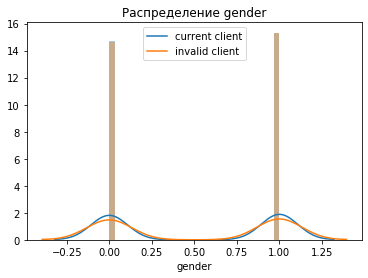

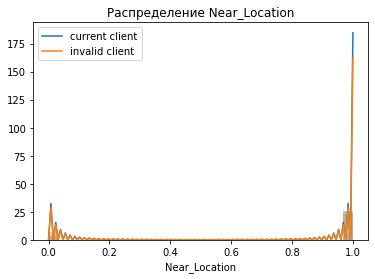

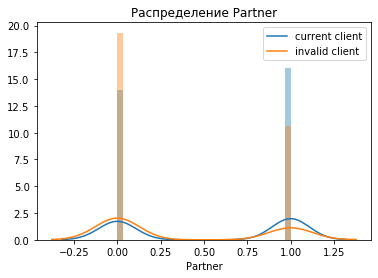

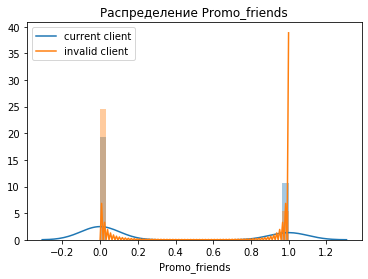

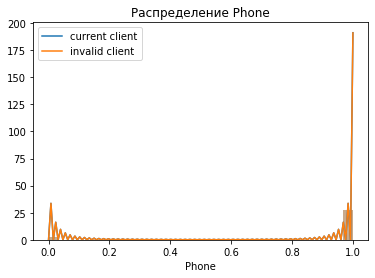

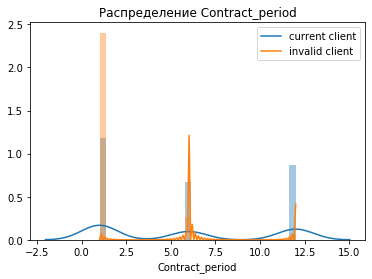

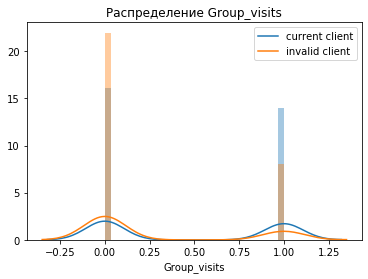

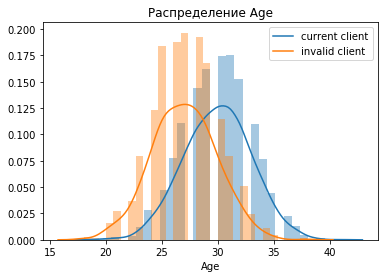

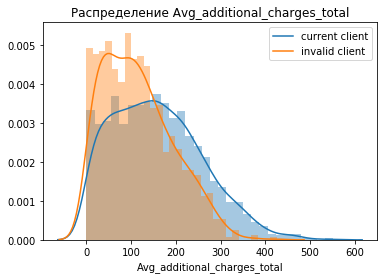

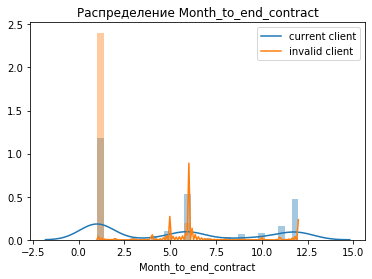

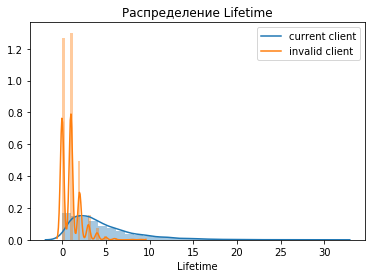

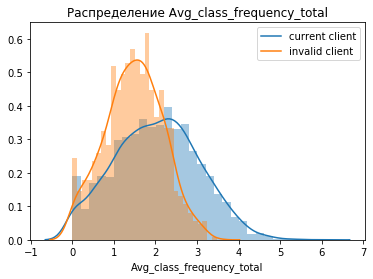

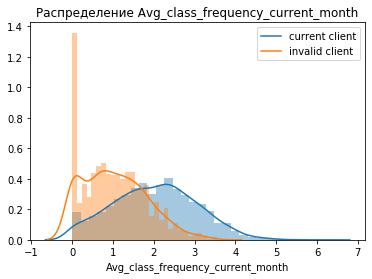

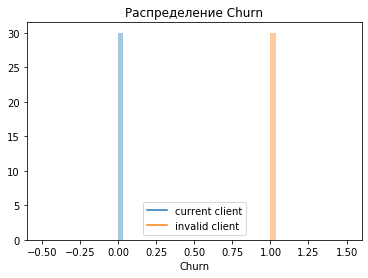

In [13]:
# Для каждого признака построим столбчатые гистограммы 

for col in current_client.columns:
    sns.distplot(current_client[col], bins = 30, kde_kws = {'label':'current client'})
    sns.distplot(invalid_client[col], bins = 30, kde_kws = {'label':'invalid client'})
    plt.title('Распределение {}'.format(col))
    plt.show()

In [14]:
df.groupby('Churn').agg({'mean'}).T


,Churn,0,1
gender,mean,0.510037,0.510839
Near_Location,mean,0.873086,0.768143
Partner,mean,0.534195,0.355325
Promo_friends,mean,0.353522,0.183789
Phone,mean,0.903709,0.902922
Contract_period,mean,5.747193,1.728558
Group_visits,mean,0.464103,0.268615
Age,mean,29.976523,26.989632
Avg_additional_charges_total,mean,158.445715,115.082899
Month_to_end_contract,mean,5.283089,1.662582


Опираясь на графики и на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался, мы можем предположить, что среди клиентов попадающих в отток на 10% больше проживающих вдали от фитнес-центра, среди них на примерно 18% меньше участников партнерской программы и участников акции «Приведи друга». Для этих клиентов характерно небольшого срока действие текущего договора (в среднем менее 2–х месяцев), срок до окончания текущего действующего договора тоже значительно ниже. Таким образом, можно предположить, что изначально такие клиенты в среднем покупают короткие абонементы не более чем на 3 месяца. 
На 20% меньше эти клиенты посещают групповые занятия. Менее лояльно относятся к кросс-покупкам в фитнес зале, их траты на доп.покупки в среднем на 27% ниже. 
Lifetime в среднем у таких клиентов ниже в несколько раз, посещают клуб они в 2 раза реже тех, кто остается клиентом.

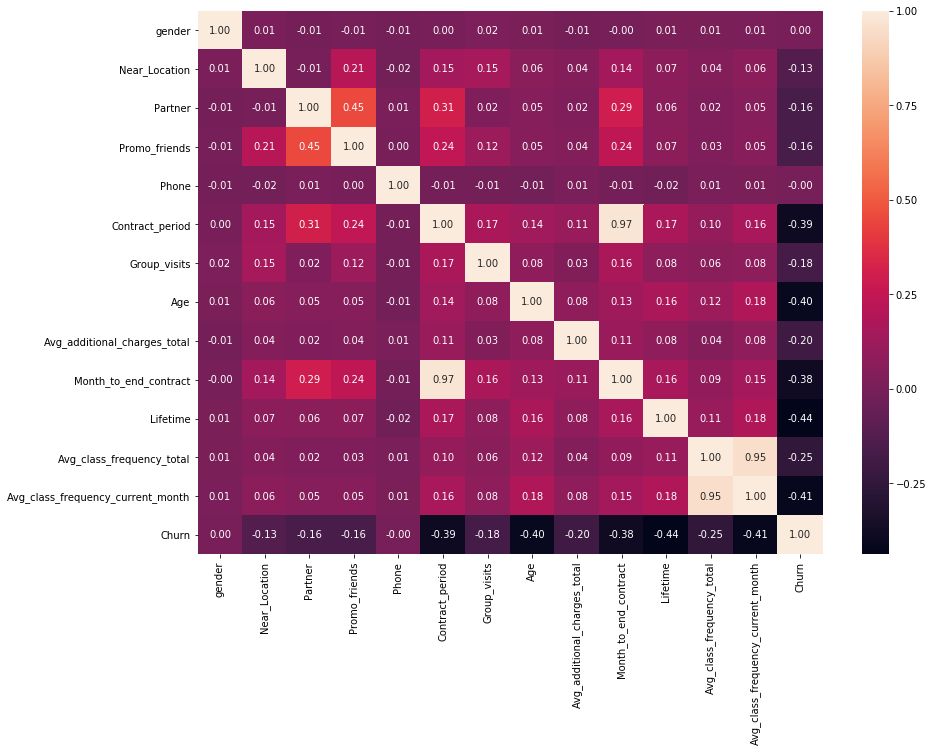

In [15]:
cm = df.corr() #вычисляем матрицу корреляций
# fig, ax = plt.subplots()

#нарисуем тепловую карту с подписями для матрицы корреляций
plt.figure(figsize=(14,10)) 
sns.heatmap(cm, annot = True, fmt=".2f") 

plt.show()

Согласно матрице корреляций признак оттока большего всего зависим от:  средняя частота посещений в неделю за все время с начала действия абонемента и за предыдущий месяц, времени с момента первого обращения в фитнес-центр, со сроком до окончания текущего действующего абонемента, от суммарной выручки от других услуг фитнес-центра, от возраста, от длительности текущего абонемента.

Не зависит от пола и указнаия  контактов.

## Модель прогнозирования оттока клиентов<a name="part_2"></a>

In [16]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [17]:
#разделим наши данные на признаки (матрица X) и целевую переменную (y)

X = df.drop('Churn', axis = 1)
y = df['Churn']

In [18]:
#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [19]:

scaler = StandardScaler() # создаём объект класса scaler (нормализатор)
scaler.fit(X_train)

# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [20]:
# задайте алгоритм логистической регресси для модели
model = LogisticRegression(solver='liblinear',random_state=0)
# обучим модель
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
probabilities = model.predict_proba(X_test)[:, 1]

# бинарный прогноз
predictions = model.predict(X_test)

In [22]:
# выведите все изученные метрики для полученного прогноза
print('Accuracy для логистической регрессии: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision для логистической регрессии: {:.2f}'.format(precision_score (y_test, predictions)))
print('Recall для логистической регрессии: {:.2f}'.format(recall_score (y_test, predictions)))

Accuracy для логистической регрессии: 0.93
Precision для логистической регрессии: 0.86
Recall для логистической регрессии: 0.83


Согласно метрикам  Модель правильно прогнозирует более чем на 80% ответов. Посчитаем roc-auc на основе прогноза вероятностей.




In [23]:
print('ROC_AUC для логистической регрессии: {:.2f}'.format(roc_auc_score(y_test, probabilities)))

ROC_AUC для логистической регрессии: 0.97


Метрика  roc-auc высокая, приближена к 1, модель работает. Посмотрим как будет работать модль обученная способом: случаный лес

In [24]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [25]:
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]

In [26]:
# выведите все изученные метрики для полученного прогноза
print('Accuracy для метода случайный лес: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision для метода случайный лес: {:.2f}'.format(precision_score (y_test, rf_predictions)))
print('Recall для метода случайный лес: {:.2f}'.format(recall_score (y_test, rf_predictions)))

Accuracy для метода случайный лес: 0.92
Precision для метода случайный лес: 0.84
Recall для метода случайный лес: 0.81


In [27]:
print('ROC_AUC для метода случайный лес: {:.2f}'.format(roc_auc_score(y_test, rf_probabilities)))

ROC_AUC для метода случайный лес: 0.97


## Кластеризация клиентов<a name="part_3"></a>

In [28]:
# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(df)

In [29]:
linked = linkage(x_sc, method = 'ward') # таблица «связок» между объектами

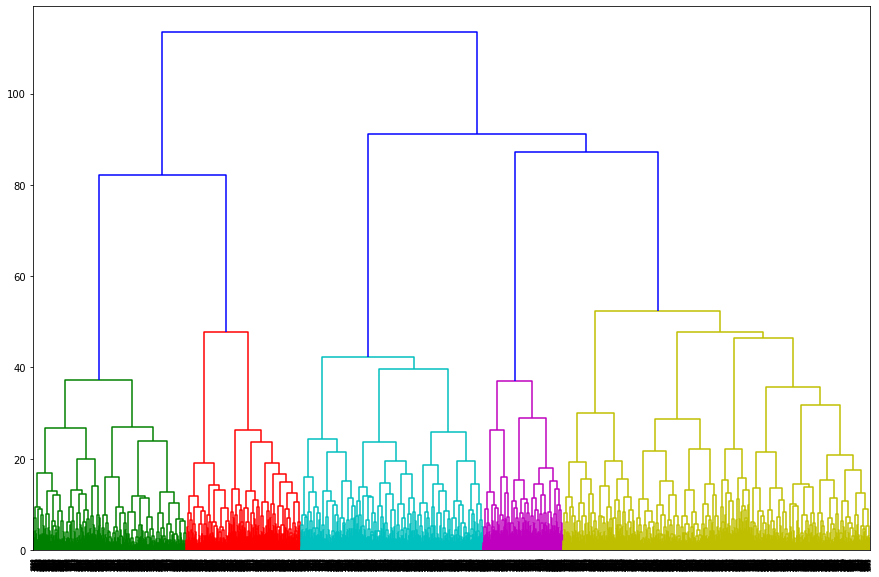

In [30]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

In [31]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5,random_state=0) 

In [32]:
labels = km.fit_predict(x_sc) # применяем алгоритм к данным и формируем вектор кластеров 

In [33]:
# сохраняем метки кластера в датасет
df['cluster'] = labels

In [34]:
# выводим статистику по средним значениям наших признаков по кластеру
cluster = df.groupby(['cluster']).mean().T
cluster

cluster,0,1,2,3,4
gender,0.503676,0.492829,0.507917,0.521186,0.518895
Near_Location,0.000000,0.936115,1.000000,0.996610,0.968023
Partner,0.459559,0.764016,0.323995,0.282203,0.744186
Promo_friends,0.075368,0.534550,0.213155,0.208475,0.526163
Phone,0.917279,0.919166,0.903776,0.904237,0.873547
Contract_period,2.069853,10.447197,1.546894,1.882203,8.859012
Group_visits,0.211397,0.516297,0.287454,0.452542,0.534884
Age,28.522059,29.962190,26.926918,30.237288,29.728198
Avg_additional_charges_total,132.741216,161.853561,113.173051,157.988625,162.907495
Month_to_end_contract,1.950368,9.477184,1.500609,1.794915,8.155523


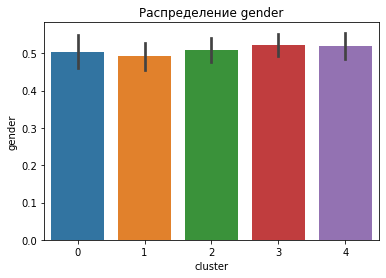

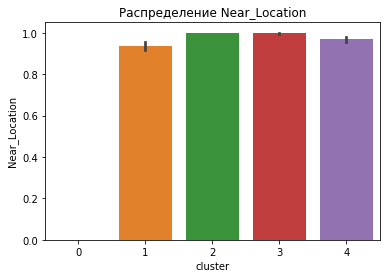

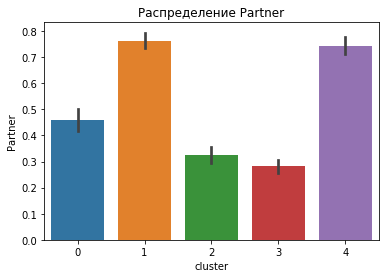

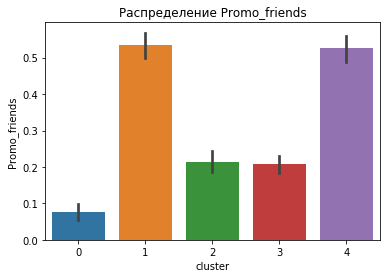

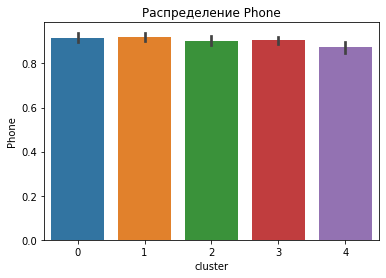

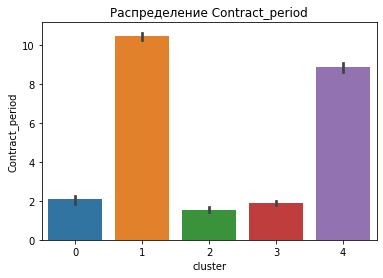

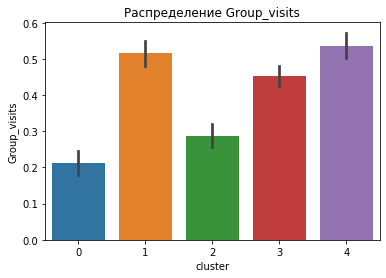

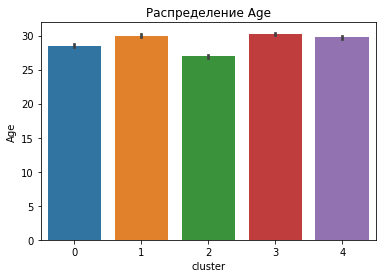

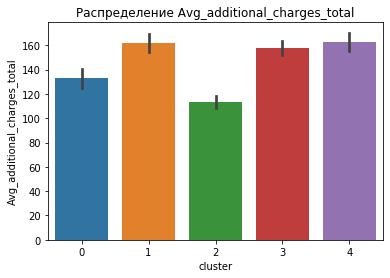

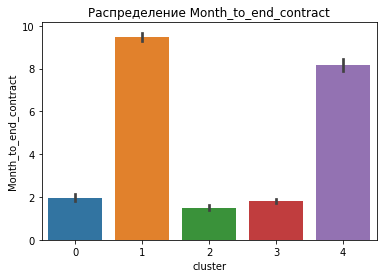

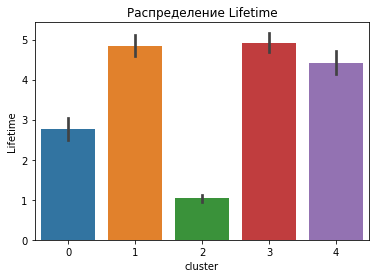

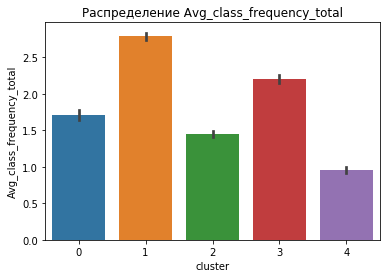

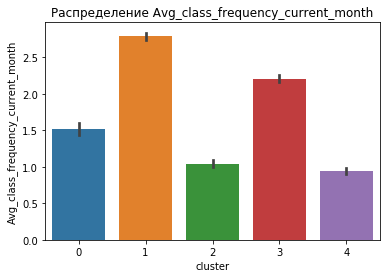

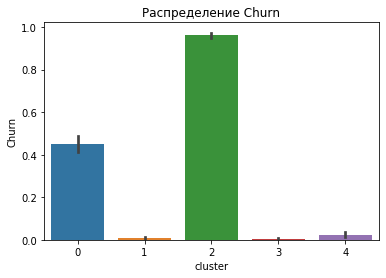

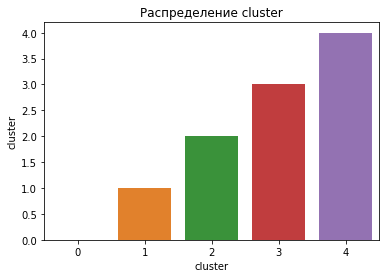

In [35]:
for col in df.columns:
    sns.barplot(x = df.cluster, y = df[col] )
    plt.title('Распределение {}'.format(col))
    plt.show()

In [36]:
#  посчитаем долю оттока по кластерам

df.groupby('cluster')['Churn'].mean()

cluster
0    0.450368
1    0.007823
2    0.961023
3    0.003390
4    0.024709
Name: Churn, dtype: float64

Составим проект каждого кластера. Пол клиентов примерно поровну разделился каждом кластере, так же в каждом кластере одинаковое количество клиентов с оставленными контактами. Средний возраст клиентов от 28-30 лет. К этим признаком не будем обращаться в описании кластеров.
Самые большие проценты оттока клиентов показали кластеры 2 и 0 кластер. Самые лучше показатели у кластеров: 2,1,4

Для клиентов нулевого кластера приходится достаточно высокая доля оттока. Составляет 45% от всех клиентов к кластере. 
Согласно графику для клиентов характерно далекое проживание от фитнес-центра, больше половины клиентов этого кластера участники партнерской программы, и совсем малая часть привлечена по реферальной программе. Длительность текущего абонемента не более 2 месяцев. Групповые занятие посещают 21% клиентов этого кластера, суммарная выручка от других услуг фитнес-центра не самый низкий показатель среди других кластеров, но и не самый высокий. До окончания действия абонемента в среднем у клиентов этого кластера остаётся не более 2 месяцев. Тк у нас есть три варианта абонемента (3,6,12 месяцев). Клиенты этого кластера чаще всего пользуются абонементом сроком на три месяца, что подтверждает признак Lifetime. В среднем клиенты этого кластера посещают фитнес –центр не более чем 2 раза в неделю.


Для клиентов первого кластера одна из самых низкой доли оттока клиентов.
95% клиентов этого кластера проживают или работают рядом с фитнес центром. Большая часть это клиенты партнёрской программы и реферальной акции. У этого кластера самый высокий период действия абонемента более 10 месяцев, а также высокий показатель Lifetime и больше всего срок действия абонента до окончания. Для клиентов этого кластера характерно покупать абонемент сроком на 12 месяцев. Групповые занятия посещает в среднем чуть больше половины клиентов этого кластера. Выручка от доп.товаров одна из самых высоких в этом кластере. В среднем клиенты этого кластера посещают фитнес – 2-3 раза в неделю.


Для клиентов второго кластера приходится самая высокая доля оттока. Составляет 96% от всех клиентов к кластере. 
Согласно графику для всех клиентов характерно близкое проживание, либо рабочее пространство к фитнес-центру, около 30% клиентов этого кластера участники партнерской программы, и 20% привлечены по реферальной программе. 
Длительность текущего абонемента 1,5 месяца. Групповые занятие посещают 28% клиентов этого кластера, суммарная выручка от других услуг фитнес-центра самая низкая среди других кластеров. 
До окончания действия абонемента в среднем у клиентов этого кластера остаётся не более 1,5 месяцев. Клиенты этого кластера чаще всего пользуются абонементом сроком на три месяца. Lifetime в среднем 1 месяц, что говорит, что абонемент эти клиенты приобрели недавно. В среднем клиенты этого кластера посещают фитнес –центр 1 раза в неделю.


Для клиентов третьего кластера самая низкая доля оттока клиентов.
99% клиентов этого кластера проживают или работают рядом с фитнес центром. Около 20 – 30% это клиенты партнёрской программы и реферальной акции. У этого кластера период действия текущего абонемента не более 2 месяцев, а также срок действия абонента до окончания составляет также не более 2 месяцев.  Lifetime в среднем до 5 месяцев.  Для клиентов этого кластера характерно покупать абонемент сроком от 3 до 6 месяцев. Групповые занятия посещает в среднем чуть меньше половины клиентов этого кластера. Выручка от доп.товаров одна из самых высоких в этом кластере. В среднем клиенты этого кластера посещают фитнес – 2-3 раза в неделю


Для клиентов четвертого кластера одна из самых низкой доли оттока клиентов.
96% клиентов этого кластера проживают или работают рядом с фитнес центром. Большая часть это клиенты партнёрской программы и реферальной акции. У этого кластера один из самых высокий период действия абонемента более 8 месяцев, а также высокий показатель Lifetime и большой срок действия абонента до окончания. Для клиентов этого кластера характерно покупать абонемент сроком на 12 месяцев. Групповые занятия посещает в среднем чуть больше половины клиентов этого кластера. Выручка от доп.товаров самая высокая в этом кластере. В среднем клиенты этого кластера посещают фитнес – 1 раз в неделю.


## Вывод:<a name="part_4"></a>

В ходе работы были проанализированы данные содержащие информацию о пользователях на месяц до оттока и факт оттока на определённый месяц фитнес-центра. 

Основные выводы:

1.	Были построены модели логистической регрессии и случайного леса, обе модели показали высокую точность - около 90%

2.	После кластеризации пользователей, были описаны портреты 5 кластеров.

3.	Проанализировав основные признаки, наиболее сильно влияющие на отток, было определено, что среди клиентов попадающих в отток на 10% больше проживающих вдали от фитнес-центра, среди них на примерно 18% меньше участников партнерской программы и участников акции «Приведи друга». Для этих клиентов характерно небольшого срока действие текущего договора (в среднем менее 2–х месяцев), срок до окончания текущего действующего договора тоже значительно ниже. Таким образом, можно предположить, что изначально такие клиенты покупают короткие абонементы не более чем на 3 месяца. На 20% меньше эти клиенты посещают групповые занятия. Менее лояльно относятся к кросс-покупкам в фитнес зале, их траты на доп.покупки в среднем на 27% ниже. Lifetime в среднем у таких клиентов ниже в несколько раз, те в отток попадают преимущественно новые клиенты фитнес-центра.  


## Рекомендации:<a name="part_5"></a>


Самая большая доля оттока в кластерах 0 и 2, для этих кластеров характерно небольшой срок действия абонента (3 месяца), и маленький срок Lifetime (около 1 месяца). Очевидно, что новые клиенты не успевают оценить преимущества фитнес-центра.
Необходимо продумать систему onboarding, адаптацию нового клиента.


Также от кластеров с самой низкой долей оттока их отличает выручка от доп.товаров, увеличение долю проникновения кросс – продаж этим клиентам, может продлить срок сотрудничества.

